In [1]:
import pandas as pd
import os

path = os.path.abspath('../weatherdata_grabber/weather_data.csv')
raw_data = pd.read_csv(path)

In [2]:
from datetime import timedelta,date

def add_datetime(raw_data):
    raw_data['Datetime'] = (raw_data['Date'] + ' ' + raw_data['Time'])
    raw_data['Datetime'] = pd.to_datetime(raw_data['Datetime'])
    weather_data = raw_data.drop(['Date','Time'],axis=1)
    
    return weather_data

def fill_missing_entries(weather_data):
    start_d = weather_data.Datetime.max()
    end_d = weather_data.Datetime.min()

    dates = pd.Series(pd.date_range(start=start_d, end=end_d, freq='-1H'))
    missing_dates = dates.loc[~dates.isin(weather_data.Datetime)]

    h = timedelta(hours=1)
    missing_rows = []

    for date in missing_dates:
        prev_date = date + h
        next_date = date - h
        while(weather_data.loc[weather_data['Datetime'] == prev_date].empty):
            prev_date = prev_date + h
        row_dict = {}
        row_dict = weather_data.loc[weather_data['Datetime'] == prev_date].to_dict('records')
        row_dict[0].update(Datetime=date)
        missing_rows.append(row_dict[0])

    weather_data = weather_data.append(missing_rows)
    weather_data = weather_data.sort_values('Datetime', ascending=True)
    weather_data = weather_data.drop_duplicates()
    weather_data = weather_data.reset_index(drop=True)
    
    return weather_data

def convert_datetime(weather_data):
    weather_data['Day'] = weather_data.Datetime.dt.day
    weather_data['Month'] = weather_data.Datetime.dt.month
    weather_data['Hour'] = weather_data.Datetime.dt.hour
    weather_data['DayofYear'] = weather_data.Datetime.dt.dayofyear
    weather_data['WeekofYear'] = weather_data.Datetime.dt.weekofyear
    weather_data['Year'] = weather_data.Datetime.dt.year
    return weather_data

def new_data(raw_data):
    weather_data = add_datetime(raw_data)
    weather_data = fill_missing_entries(weather_data)
    weather_data = convert_datetime(weather_data)
    return weather_data

weather_data = new_data(raw_data)

Text(0, 0.5, 'Temperture(°F)')

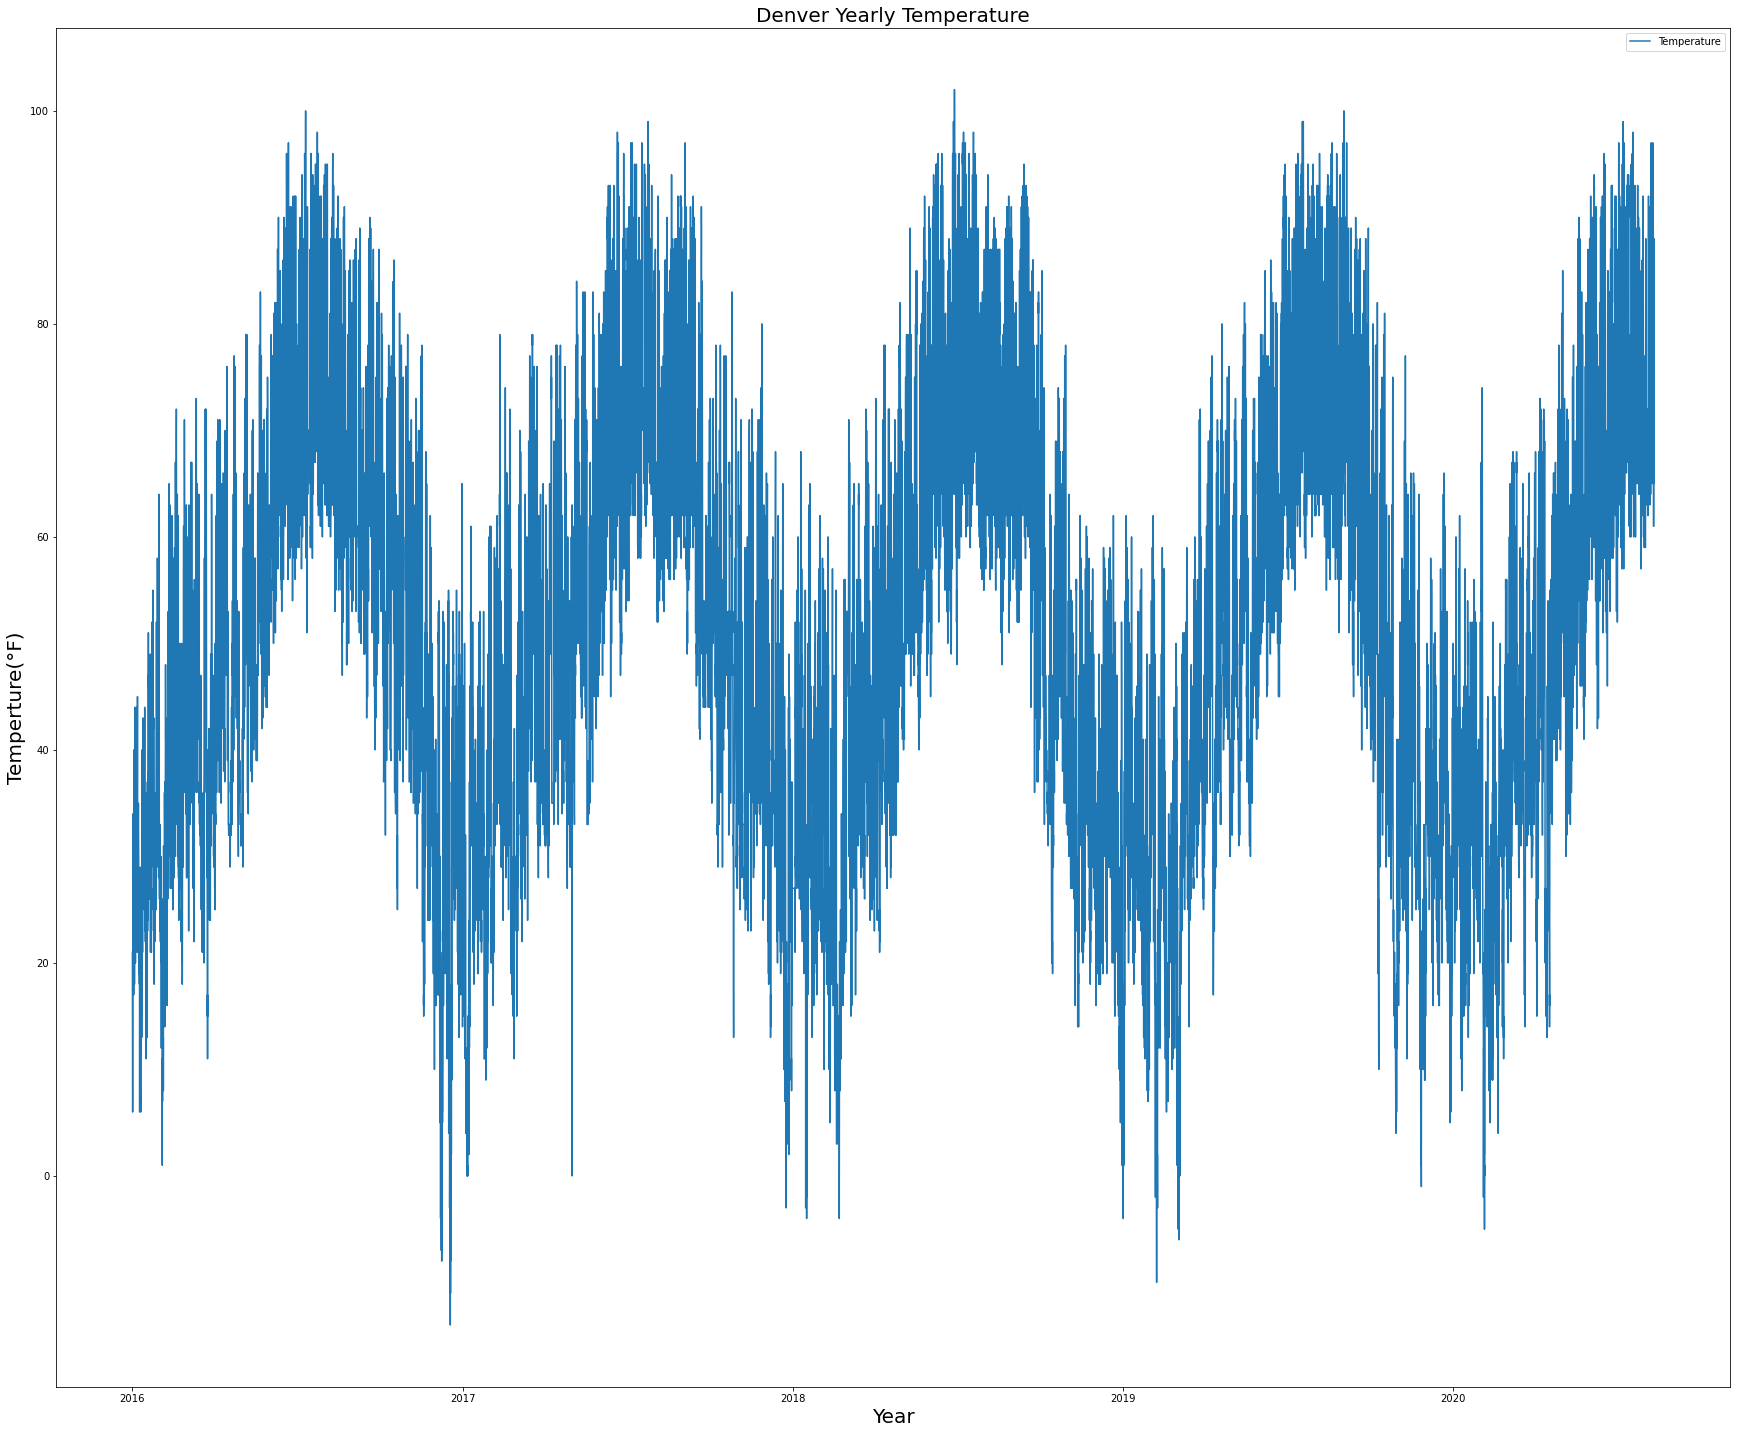

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

data = weather_data[['Datetime','Temperature']].set_index('Datetime')

plt.figure(figsize=(30,25))
plt.title('Denver Yearly Temperature', fontsize=20)


sns.lineplot(data=data, ci=None)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Temperture(°F)', fontsize=20)


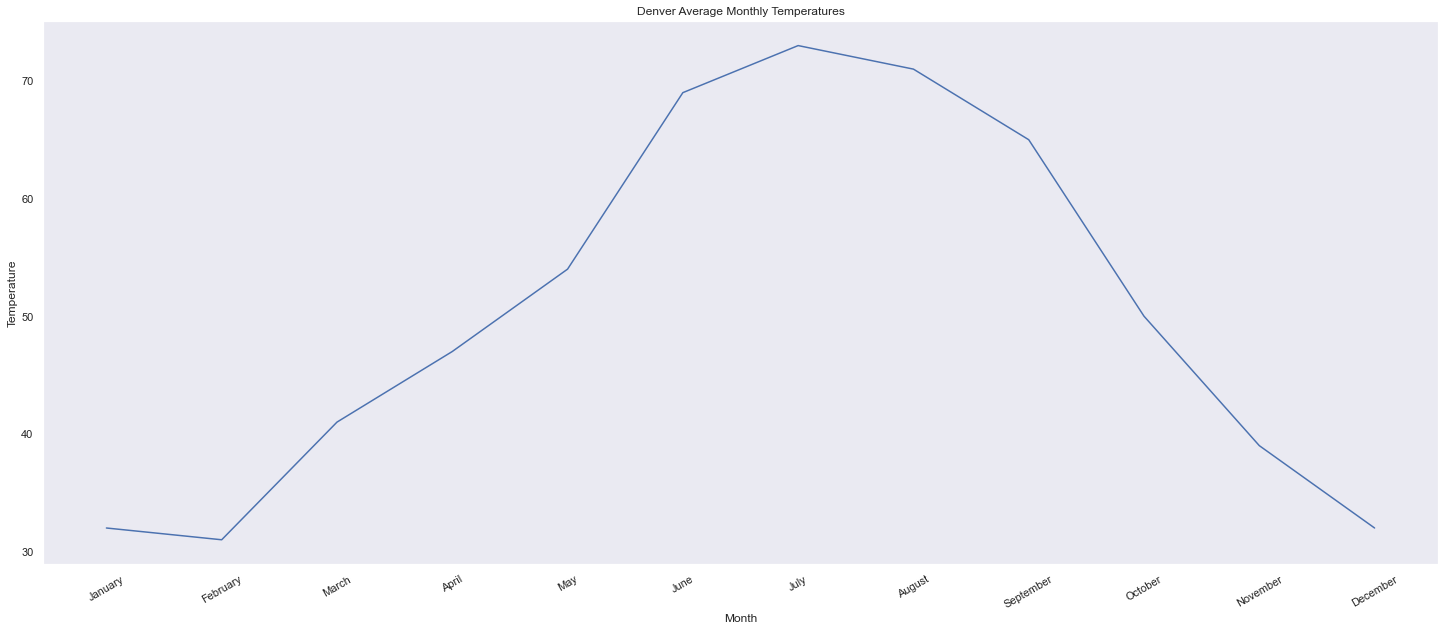

In [4]:
data = weather_data[['Month','Temperature']].groupby('Month').median()

sns.set(style='dark')
plt.figure(figsize=(25,10))
plt.title("Denver Average Monthly Temperatures")
plt.xticks([x for x in range(1,13)],['January', 'February', 'March','April','May','June','July',
                                        'August','September','October','November','December'], rotation=30)
sns.lineplot(data.index, y = data.Temperature, data=data)

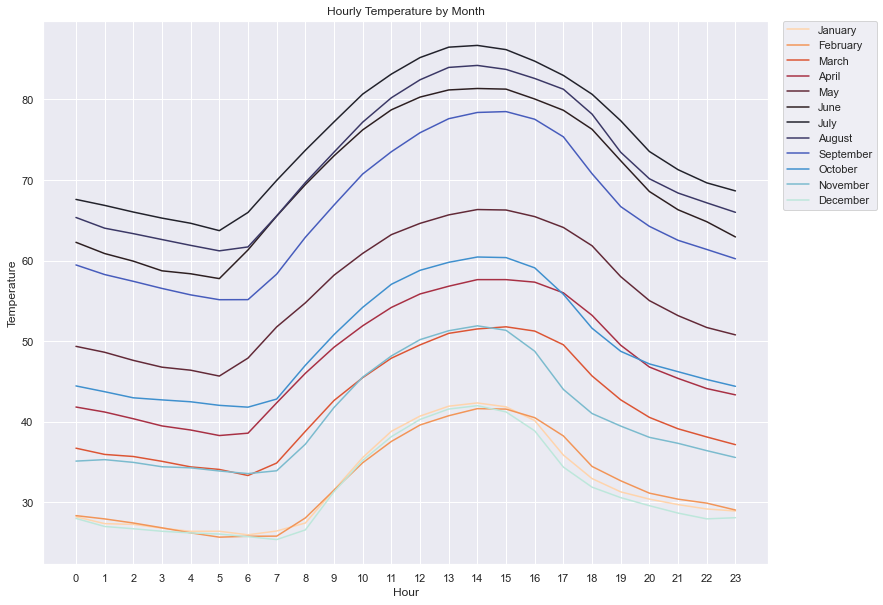

In [5]:
data = weather_data[['Month','Hour','Temperature']]
months = ['January', 'February', 'March','April','May','June','July',
                                        'August','September','October','November','December']
sns.set(style='darkgrid')
plt.figure(figsize=(13,10))
plt.xticks([x for x in range(0,24)])
plt.title('Hourly Temperature by Month')
sns.lineplot(x='Hour',y='Temperature',hue='Month',data=data, palette='icefire_r', ci=None, legend='full')
plt.legend(months, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.0 )

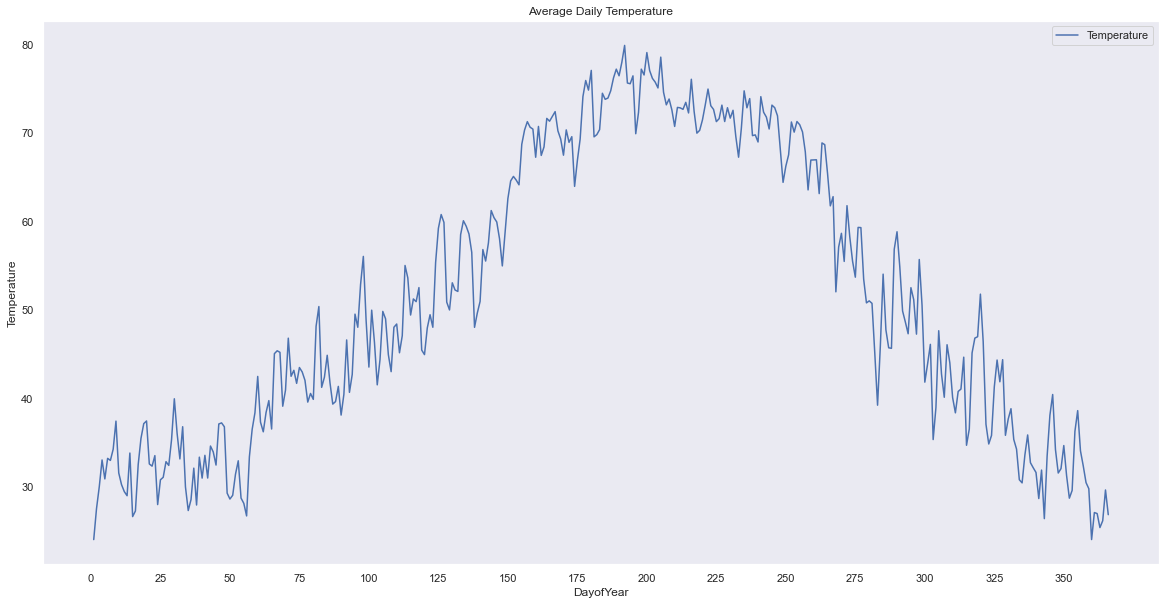

In [6]:
sns.set(style='dark')

plt.figure(figsize=(20,10))
plt.title('Average Daily Temperature')
plt.xticks([x for x in range(0,366,25)])
plt.ylabel('Temperature')

sns.lineplot(data=weather_data[['DayofYear','Temperature']].groupby('DayofYear').mean(), ci=None)

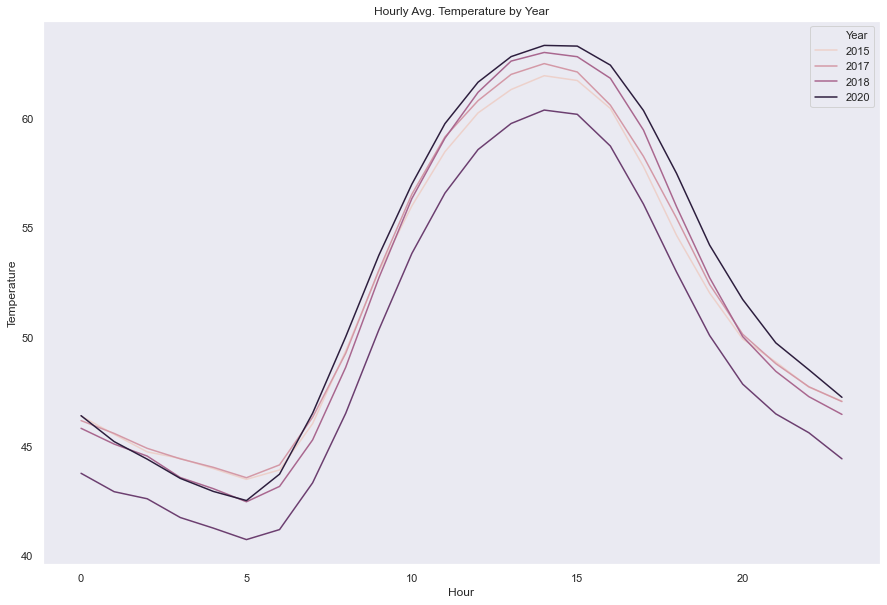

In [7]:
# g = sns.FacetGrid(weather_data,row='Year',row_order=[2016,2017,2018,2019],height=3,aspect=4)
# g.map(sns.lineplot,"DayofYear","Temperature",ci=95)
sns.set(style='dark')
plt.figure(figsize=(15,10))
plt.title('Hourly Avg. Temperature by Year')
sns.lineplot(x='Hour', y='Temperature', hue='Year', data=weather_data, ci=None)

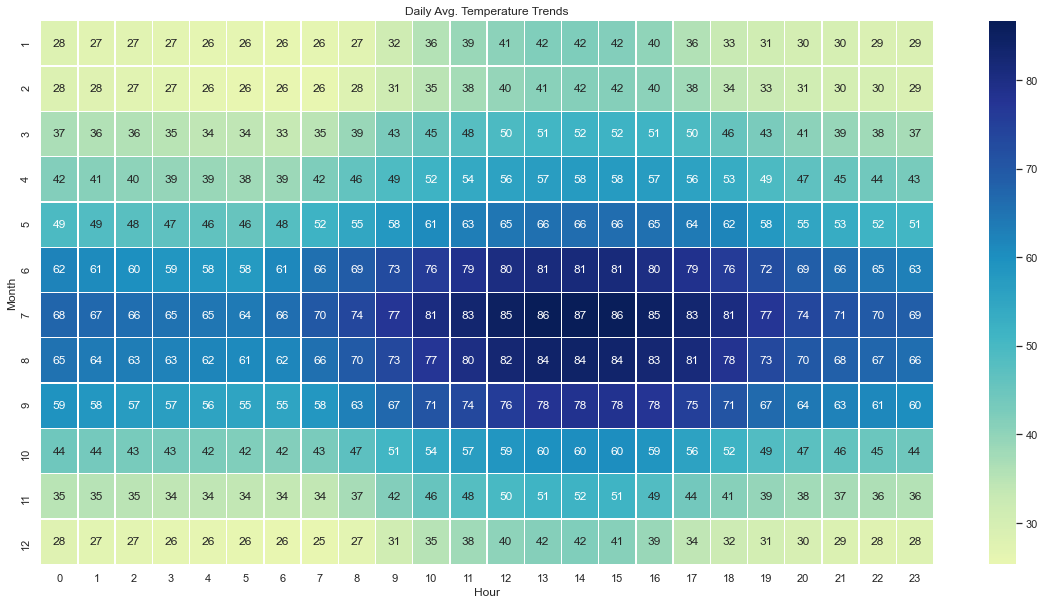

In [8]:
data = weather_data[['Month','Hour','Temperature']]
data = data.pivot_table(values='Temperature',index='Month', columns='Hour',aggfunc='mean')
plt.figure(figsize=(20,10))
plt.title('Daily Avg. Temperature Trends')
sns.heatmap(data=data, annot=True, linewidths=.3,center=51,cmap='YlGnBu')

In [9]:
from sklearn.model_selection import train_test_split


weather_data['Prev_Temp'] = weather_data['Temperature'].shift()
weather_data['Prev_Temp_Diff'] = weather_data.loc[:,'Prev_Temp'].diff()
weather_data = weather_data.dropna()

features = ['Hour','DayofYear','Month', 'Day','Year','Prev_Temp','Prev_Temp_Diff']
X = pd.get_dummies(weather_data[features])
y = weather_data.Temperature

train_X,test_X,train_y, test_y = train_test_split(X,y,test_size=.2, random_state=23, shuffle=False)

In [10]:
from math import sqrt
from sklearn.metrics import mean_squared_error

baseline = train_y.shift(24).dropna()

print("baseline to beat root mean squared error %.5f" %(sqrt(mean_squared_error(train_y.tail(24),baseline.tail(24)))))

baseline to beat root mean squared error 11.84096


In [11]:
from sklearn import linear_model
from lightgbm import LGBMRegressor

def model_eval(model, train_X, train_y, test_X, test_y):
    model.fit(train_X,train_y)
    predictions = model.predict(test_X)
    
    print("root mean squared error %.5f" %(sqrt(mean_squared_error(test_y,predictions))))
    return predictions

In [12]:
model = LGBMRegressor(n_estimatorts=1000,learning_rate=0.1)
p3 = model_eval(model,train_X,train_y,test_X,test_y)

root mean squared error 2.81314


In [13]:
model = linear_model.Ridge(alpha=.5)
p3 = model_eval(model,train_X,train_y,test_X,test_y)

root mean squared error 3.64057


In [14]:
final_model = LGBMRegressor(n_estimatorts=1000,learning_rate=0.1) #model wiht lowest RMSE
final_model.fit(X,y)

one_hour = timedelta(hours=1)
to_predict = pd.DataFrame()
temp = weather_data[['Temperature','Datetime']].tail(1)
temp['Datetime'] = temp['Datetime'] + one_hour
temp.reset_index(inplace=True,drop=True)

to_predict['Hour'] = temp['Datetime'].dt.hour
to_predict['DayofYear'] = temp['Datetime'].dt.dayofyear
to_predict['Month'] = temp['Datetime'].dt.month
to_predict['Day'] = temp['Datetime'].dt.day
to_predict['Year'] = temp['Datetime'].dt.year

to_predict['Prev_Temp'] = temp['Temperature']
to_predict['Prev_Temp_Diff'] = weather_data['Temperature'].values[-1] - weather_data['Temperature'].values[-2]

tom_temps = final_model.predict(to_predict)

for i in range(1,24):
    to_predict.loc[i] = to_predict.loc[i-1]
    to_predict.loc[i].Hour = i
    to_predict.loc[i].Prev_Temp = round(tom_temps.item(i-1))
    to_predict.loc[i].Prev_Temp_Diff = to_predict.loc[i].Prev_Temp - to_predict.loc[i-1].Prev_Temp
    tom_temps = final_model.predict(to_predict)

predicted_temps = pd.DataFrame()
predicted_temps['Predicted_Temp'] = tom_temps

In [15]:
from datetime import datetime

t = weather_data[['DayofYear','Hour','Temperature']].loc[weather_data.DayofYear == (datetime.now().timetuple().tm_yday)]

predicted_temps['Average_Temp'] = t.groupby(['DayofYear','Hour']).mean().reset_index().drop(['Hour','DayofYear'],axis=1)
predicted_temps['Yesterday\'s Temp'] = weather_data.Temperature.iloc[-24:].reset_index(drop=True)

In [16]:
predicted_temps
#index is the hourly temperature

,Predicted_Temp,Average_Temp,Yesterday's Temp
0,70.572980,63.250000,71
1,69.266301,63.750000,65
2,67.547930,62.000000,69
3,66.721247,60.000000,70
4,65.800154,58.750000,61
5,65.055002,57.750000,61
6,65.450102,58.000000,61
7,67.892958,64.000000,62
8,72.324042,69.250000,66
9,75.943401,72.750000,69
